# Class Activation Mapping - Proof-of-Concept

**Author**: Johannes S. Fischer

Visualize where a neural network looks at ([paper](https://openaccess.thecvf.com/content_cvpr_2016/html/Zhou_Learning_Deep_Features_CVPR_2016_paper.html)).

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

## Load Model

In [2]:
model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')

model.summary()

96124928/96112376 [==============================] - 17s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)          

## Input Image

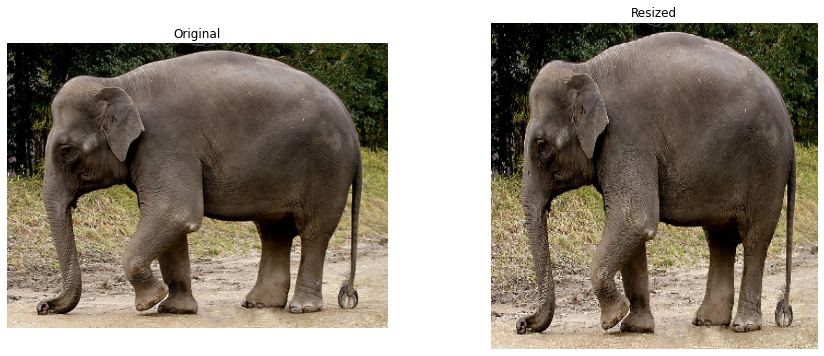

In [3]:
IMG_NAME = 'elephant.jpg'

DIM = 299

img = tf.keras.preprocessing.image.load_img('./data/' + IMG_NAME, target_size=(DIM, DIM))

plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(plt.imread('./data/' + IMG_NAME))
plt.axis('off')
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(img)
plt.axis('off')
plt.title('Resized')

plt.show()

Preprocess image for the use as model input.

In [4]:
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.inception_v3.preprocess_input(x)

preds = model.predict(x)
print(tf.keras.applications.inception_v3.decode_predictions(preds))

[[('n02504013', 'Indian_elephant', 0.9624188), ('n01871265', 'tusker', 0.01518696), ('n02504458', 'African_elephant', 0.0004736364), ('n04346328', 'stupa', 0.00033352844), ('n01694178', 'African_chameleon', 0.0002956223)]]


## Class Activation Map
Get feature maps from last convolutional layer.

In [5]:
last_conv_layer_name = 'mixed10'

last_conv_layer = model.get_layer(last_conv_layer_name)

model_fm = tf.keras.Model(inputs=model.inputs, outputs=[model.output, last_conv_layer.output])

model_out, feature_maps = model_fm.predict(x)

feature_maps = np.squeeze(feature_maps)

print("Model output: ", model_out.shape)
print("Feature maps: ", feature_maps.shape)

Model output:  (1, 1000)
Feature maps:  (8, 8, 2048)


Get weights from GAP to softmax.

In [6]:
weights = model.layers[-1].weights[0]
print("Weights shape: ", weights.shape)

Weights shape:  (2048, 1000)


Get only the weights for the winning class. To do so, we have to find the index of the maximum of the network's output.

In [7]:
max_idx = np.argmax( np.squeeze(model_out) )
print(f"Maximum index {max_idx} with confidence {model_out[0][max_idx]*100:.2f}%")

Maximum index 385 with confidence 96.24%


The ```weights``` have shape $n_f \times n_o$, where $n_f$ is the number of feature maps or number of neurons in the ```global average pooling``` layer, and $n_o$ is the number of outputs or the number of classes the model is able to predict.

| | $o_1$ | $o_2$ | $o_3$ | - |
|:--:|:--:|:--:|:--:|:--:|
| $f_1$ | $w_{11}$ | $w_{12}$ | $w_{13}$ | ... |
| $f_2$ | $w_{21}$ | $w_{22}$ | $w_{23}$ | ... |
| $f_3$ | $w_{31}$ | $w_{32}$ | $w_{23}$ | ... |
| ----- | $w_{n_f 1}$ | $w_{12}$ | $w_{13}$ | ... |

To get the weights corresponding to the winning class, we need to get all rows of the column at position ```max_idx```.

In [8]:
winning_weights = weights[:, max_idx]
print("Winning weights shape: ", winning_weights.shape)

Winning weights shape:  (2048,)


We see that the weight vector for the winning class has exactly the same number of rows, as we have feature maps in the last layer.

Now we need to multiply the weight vector $\mathbf{w}$ with the feature map matrix $F \in \mathbb{R}^{w \times w \times n_f}$. For example, for feature map $k$ we multiply each entry in $F_k \in \mathbb{R}^{w \times w}$ with the scalar value $w_k$.

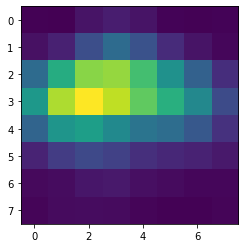

Wall time: 1.37 s


In [9]:
%%time
CAM = np.zeros(feature_maps.shape[:2])
for k, wk in enumerate(winning_weights):
    # get feature map k
    feature_map_k = feature_maps[..., k]
    
    # get activation of map k (multiply Fk with wk)
    activation_k = feature_map_k * wk
    
    CAM += activation_k
plt.imshow(CAM)
plt.show()

Faster method.

(8, 8)


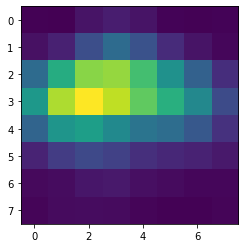

Wall time: 278 ms


In [10]:
%%time
CAM = np.sum(feature_maps * winning_weights, axis=2)
print(CAM.shape)
plt.imshow(CAM)
plt.show()

## Result

Now that we have the feature map, we need to upscale it, so that we can lay it on top of the image.

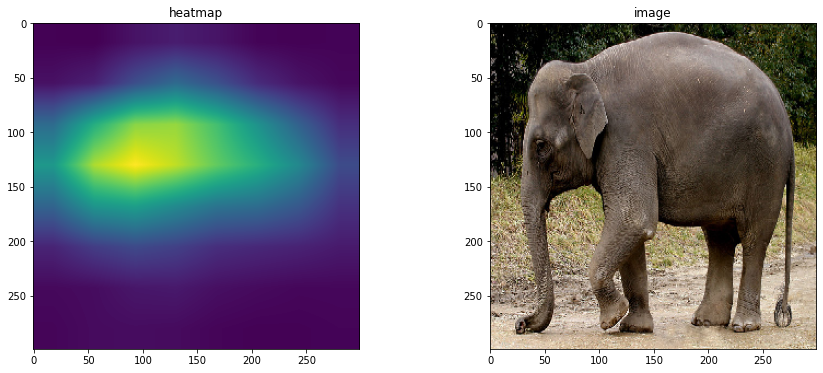

In [11]:
# resize CAM
heatmap = cv2.resize(CAM, (DIM, DIM))

# plot heatmap and image side by side
plt.subplots(1, 2, figsize=(15, 6))

plt.subplot(1,2,1)
plt.imshow(heatmap)
plt.title('heatmap')

plt.subplot(1,2,2)
plt.imshow(img)
plt.title('image')

plt.show()

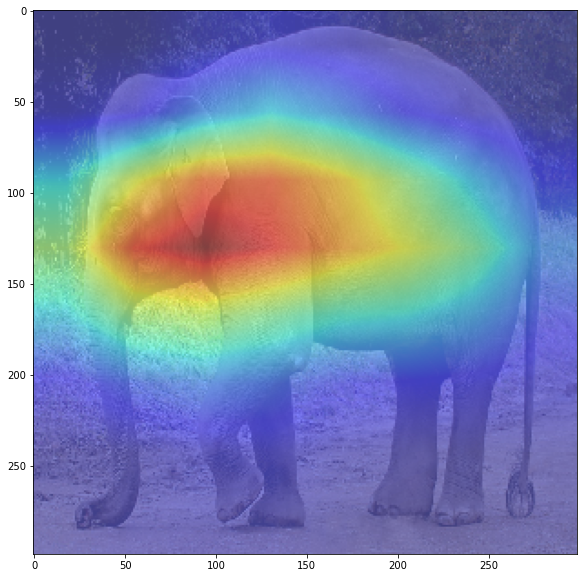

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(img, alpha=0.5)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.show()

## Function

In [ ]:
def get_CAM(model, image, )

---